In [1]:
%matplotlib widget

In [2]:
from crank_nicolson_2d import *

In [3]:
import numpy as np

In [4]:
def tunnelCase(position, where, width, potential = 1): 
    return np.where(
            (position.x > where) & (position.x < (where + width)), 
            potential, 
            0, 
        )

In [5]:
def hydrogenAtom(position, potential, bottom = 1): 
    return potential / np.sqrt(
            (position.x / 2) ** 2 \
            + (position.y / 2) ** 2 \
            + bottom ** 2 \
        )

In [6]:
def doubleSlit(position, where, width, slitHeight, gapHeight, potential = 1, math=np): 
    totalY = math.max(position.y)
    return math.where(
            (position.x > where) & (position.x < (where + width)) 
                    & ( \
                            (position.y > ((totalY / 2) + (gapHeight + slitHeight))) \
                            | (position.y < ((totalY / 2) - (gapHeight + slitHeight))) \
                            | ( \
                               (position.y > ((totalY / 2) - gapHeight)) \
                               & (position.y < ((totalY / 2) + gapHeight)) \
                              )
                      ), 
            potential, 
            0, 
        )

In [7]:
def constantPotentials(position, lengthRatios, potentialRatios, basePotential, math = np, epsilon = 1e-16): 
    regionCount = len(lengthRatios)
    assert regionCount == len(potentialRatios)
    assert (math.sum(lengthRatios) - 1.0) < epsilon
    potential = position.x * 0.0
    basePosition = math.min(position.x)
    xExtent = math.abs(math.max(position.x) - basePosition)
    for ii in range(regionCount): 
        regionEnd = basePosition + (xExtent * lengthRatios[ii])
        potential = math.where(
                (position.x >= basePosition) & (position.x < regionEnd), 
                potentialRatios[ii] * basePotential, 
                potential
            )
        basePosition = regionEnd
    return potential

In [8]:
spatialStep : float = 1e-2
temporalStep : float = (spatialStep ** 2) / 4
courantNumber : float = 1.0
pointCount : int = int(1 / spatialStep)
barrierStart : float = .5
barrierWidth : float = .1
potentialHeight : float = 20000
print("Point Count: ", pointCount)
packetStartX : float = .8
packetStartY : float = .5
packetStandardDeviation : float = .05
packetWaveNumber : float = 15 * np.pi
constantStairwellLengthRatios : List[float] = [barrierStart, barrierWidth / 3, barrierWidth / 3, barrierWidth / 3, 1 - (barrierStart + barrierWidth)]
constantStairwellPotentialRatios : List[float] = [0, 1 / 3, 2 / 3, 1, 0]
backend = "numpy"

Point Count:  100


In [9]:
assert (temporalStep / spatialStep) <= courantNumber
profile = SimulationProfile(
        makeLinspaceGrid(pointCount, 1, 2, False, float, np), 
        lambda position : makeWavePacket(
                position, 
                packetStartX, 
                packetStartY, 
                spatialStep, 
                packetStandardDeviation, 
                packetWaveNumber, 
                np
            ), 
        lambda position, time : constantPotentials(
                position, 
                constantStairwellLengthRatios, 
                constantStairwellPotentialRatios, 
                potentialHeight
            ), 
        temporalStep, 
        spatialStep, 
        False, 
        True
    )
simulator = Simulator(profile)
simulator.simulate(500, False)
probabilities, probabilityDecibles = simulator.processProbabilities()

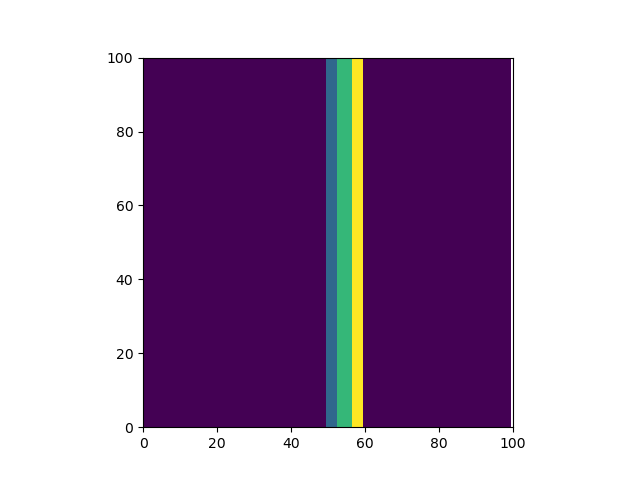

In [10]:
potentialAnimation = animateImages(pointCount, simulator.potentials)

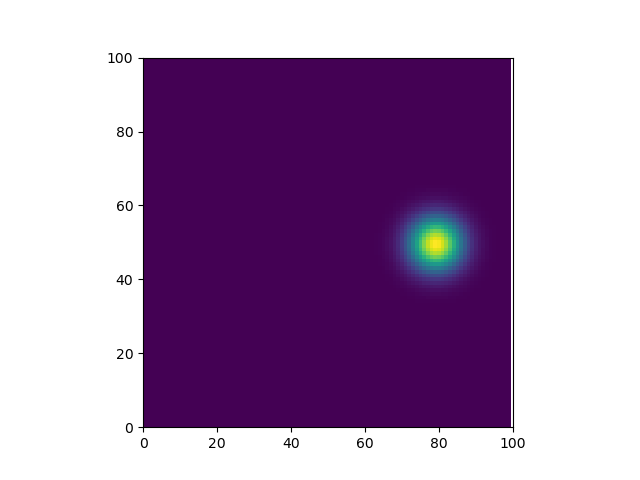

In [11]:
waveAnimation = animateImages(pointCount, simulator.probabilities, interval = 50)

In [12]:
postBarrierProbabilities, postBarrierCutFrames = totalProbabilityInRegion(
        probabilities, 
        pointCount, 
        spatialStep, 
        0, 
        0, 
        barrierStart, 
        1
    )

In [13]:
preBarrierProbabilities, preBarrierCutFrames = totalProbabilityInRegion(
        probabilities, 
        pointCount, 
        spatialStep, 
        barrierStart + barrierWidth, 
        0, 
        1 - (barrierStart + barrierWidth), 
        1
    )

In [14]:
intraBarrierProbabilities, intraBarrierCutFrames = totalProbabilityInRegion(
        probabilities, 
        pointCount, 
        spatialStep, 
        barrierStart, 
        0, 
        barrierWidth, 
        1
    )

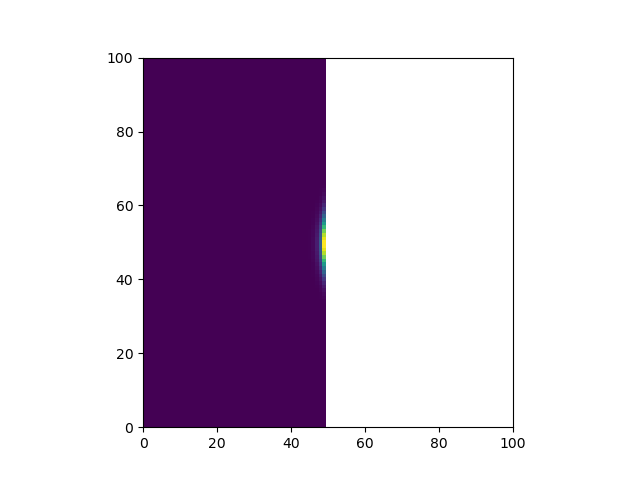

In [15]:
cutAnimationPostBarrier = animateImages(pointCount, postBarrierCutFrames, interval = 50)

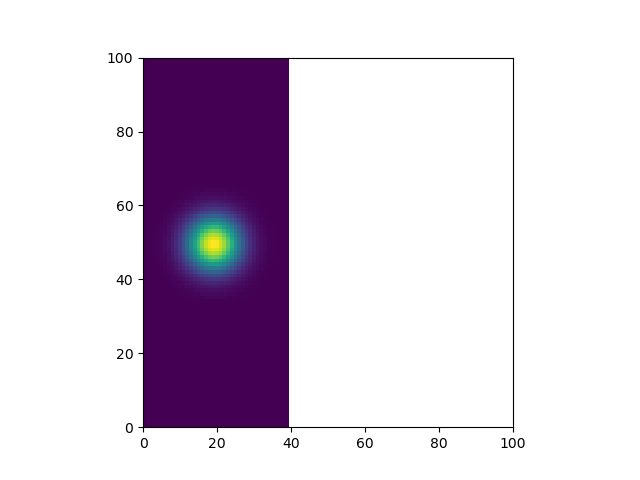

In [16]:
cutAnimationPreBarrier = animateImages(pointCount, preBarrierCutFrames, interval = 50)

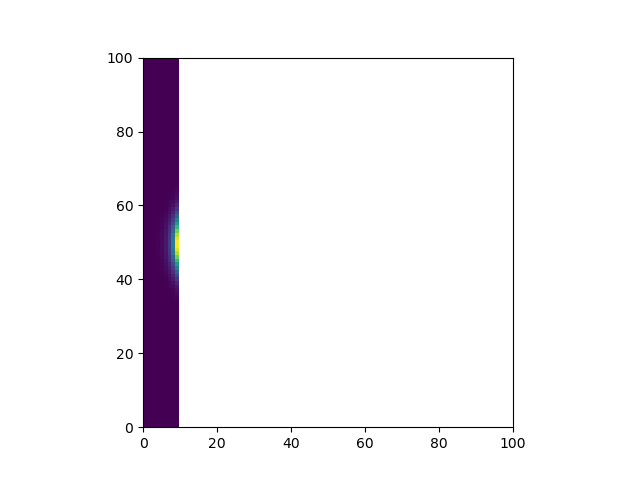

In [17]:
cutAnimationIntraBarrier = animateImages(pointCount, intraBarrierCutFrames, interval = 50)

Text(0.5, 1.0, 'Stairwell Measured by Quantum Tunneling Regions: Total Probability in Different Regions')

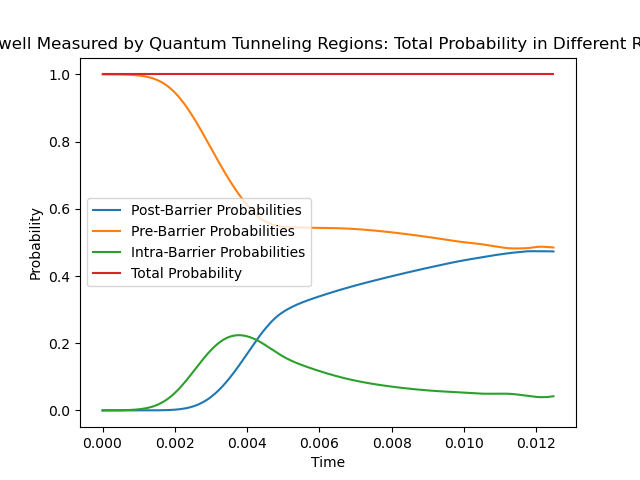

In [18]:
plt.figure()
time = np.arange(len(postBarrierProbabilities)) * temporalStep
plt.plot(time, postBarrierProbabilities)
plt.plot(time, preBarrierProbabilities)
plt.plot(time, intraBarrierProbabilities)
plt.plot(time, postBarrierProbabilities + intraBarrierProbabilities + preBarrierProbabilities)
plt.legend([
        "Post-Barrier Probabilities", 
        "Pre-Barrier Probabilities", 
        "Intra-Barrier Probabilities", 
        "Total Probability"
    ])
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Stairwell Measured by Quantum Tunneling Regions: Total Probability in Different Regions")

In [19]:
import pandas as pd

In [20]:
frame = pd.DataFrame({
        "Post-Barrier-Probabilities" : postBarrierProbabilities, 
        "Pre-Barrier-Probabilities" : preBarrierProbabilities, 
        "Intra-Barrier-Probabilities" : intraBarrierProbabilities, 
        "Total-Probability" :  postBarrierProbabilities + intraBarrierProbabilities + preBarrierProbabilities, 
        "Time" : time, 
        "spatialStep" : spatialStep, 
        "temporalStep" : temporalStep, 
        "courantNumber" : courantNumber, 
        "pointCount" : pointCount, 
        "barrierStart" : barrierStart, 
        "barrierWidth" : barrierWidth, 
        "potentialHeight" : potentialHeight, 
        "packetStartX" : packetStartX, 
        "packetStartY" : packetStartY, 
        "packetStandardDeviation" : packetStandardDeviation, 
        "packetWaveNumber" : packetWaveNumber, 
        "constantStairwellLengthRatios" : str(constantStairwellLengthRatios), 
        "constantStairwellPotentialRatios" : str(constantStairwellPotentialRatios), 
        "backend" : backend, 
    })

In [27]:
#frame.to_csv("QuantumStairwell0.csv")

In [28]:
#waveAnimation.save("QuantumStairwell0.mp4")